# Hashing

Function `get_circuit_hash` calculates SHA256 hash for given quantum circuit.

Hash is based on properties of circuit gates:

- Instruction class (RX, CNOT, CRZ, etc.)
- Parameter values (angles)
- Used qubits
- Used classical bits

Parameter names are ignored - circuits with not-bound RZ("theta_1") and RZ("theta_2") will have equal hashes.

Inspired by Qiskit `soft_compare` gate function:

https://github.com/Qiskit/qiskit/blob/main/qiskit/circuit/instruction.py#L227

### Imports

In [1]:
import qiskit

from qiskit.visualization import plot_gate_map

from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2

from time import time
from matplotlib import pyplot as plt

plt.style.use("dark_background")

In [2]:
%cd ../..

from rivet_transpiler import get_circuit_hash

from rivet_transpiler import get_litmus_circuit
from rivet_transpiler import transpile

/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler


### Backend

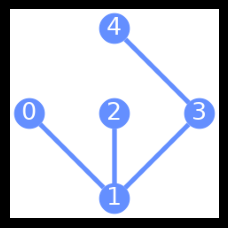

In [3]:
backend = FakeLimaV2()
# backend = FakeMontrealV2()

qiskit.visualization.plot_gate_map(backend)

### Circuit

In [4]:
QUBITS_COUNT = 3

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

### Compare Simple Hashes

In [5]:
xh_circuit = qiskit.QuantumCircuit(2)

xh_circuit.x(0)
xh_circuit.h(1)

xh_circuit.draw()

get_circuit_hash(xh_circuit)

71507776735348677072999221727313793042647835194143529330484091645604103827566

In [6]:
hx_circuit = qiskit.QuantumCircuit(2)

hx_circuit.h(1)
hx_circuit.x(0)

hx_circuit.draw()

get_circuit_hash(hx_circuit)

71507776735348677072999221727313793042647835194143529330484091645604103827566

### Compare Parameters Hashes

In [7]:
def bind_parameters_with_offset(circuit, offset=0):

    bound_circuit = circuit.copy()

    for index, parameter in enumerate(bound_circuit.parameters):

        bound_circuit.assign_parameters(
            {parameter: index + offset},
            inplace=True)

    return bound_circuit

In [8]:
# Bound Circuits

bound_circuit = bind_parameters_with_offset(litmus_circuit, offset=0)
bound_circuit_same_parameters = bind_parameters_with_offset(litmus_circuit, offset=0)
bound_circuit_other_parameters = bind_parameters_with_offset(litmus_circuit, offset=1)

# Hashes

circuit_hash = get_circuit_hash(bound_circuit)
circuit_same_parameters_hash = get_circuit_hash(bound_circuit_same_parameters)
circuit_other_parameters_hash = get_circuit_hash(bound_circuit_other_parameters)

In [9]:
# Display Circuits

display(bound_circuit.draw(fold=-1))
display(bound_circuit_same_parameters.draw(fold=-1))
display(bound_circuit_other_parameters.draw(fold=-1))

┌───────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(0) ├──■───────┤ X ├───░────
            ├───────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(1) ├┤ X ├──■────┼─────░────
            ├───────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(2) ├─────┤ X ├──■─────░────
            └───────┘     └───┘        ░

┌───────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(0) ├──■───────┤ X ├───░────
            ├───────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(1) ├┤ X ├──■────┼─────░────
            ├───────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(2) ├─────┤ X ├──■─────░────
            └───────┘     └───┘        ░

┌───────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(1) ├──■───────┤ X ├───░────
            ├───────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(2) ├┤ X ├──■────┼─────░────
            ├───────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(3) ├─────┤ X ├──■─────░────
            └───────┘     └───┘        ░

In [10]:
# Display Hashes

display(get_circuit_hash(bound_circuit))
display(get_circuit_hash(bound_circuit_same_parameters))
display(get_circuit_hash(bound_circuit_other_parameters))

10033460680529423832288923830260624451335426098717749005707346276546548518421

10033460680529423832288923830260624451335426098717749005707346276546548518421

96311980127339149651295543283381731758114225806793066312244782303502616987800

### Compare Structure Hashes

In [11]:
# Circuits

transpiled_litmus_circuit = transpile(
    litmus_circuit, 
    backend,
    # optimization_level=3,
    # initial_layout=[1, 2, 3],
    seed_transpiler=1234,
)

transpiled_litmus_circuit_same_seed = transpile(
    litmus_circuit, 
    backend,
    # optimization_level=3,
    # initial_layout=[1, 2, 3],
    seed_transpiler=1234,
)

transpiled_litmus_circuit_other_seed = transpile(
    litmus_circuit, 
    backend,
    # optimization_level=3,
    # initial_layout=[1, 2, 3],
    seed_transpiler=777,
)

In [12]:
# Display Circuits

display(transpiled_litmus_circuit.draw(fold=-1))
display(transpiled_litmus_circuit_same_seed.draw(fold=-1))
display(transpiled_litmus_circuit_other_seed.draw(fold=-1))

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

┌──────────────┐          ┌───┐          ┌───┐ Litmus 
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├───────■──┤ X ├──■───────┤ X ├───░────
                ├──────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘   ░    
Litmus_0_0 -> 1 ┤ Rz(Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■─────░────
                ├──────────────┤┌─┴─┐└───┘     └───┘└─┬─┘        ░    
Litmus_0_1 -> 2 ┤ Rz(Litmus_1) ├┤ X ├─────────────────■──────────░────
                └──────────────┘└───┘                            ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

┌──────────────┐     ┌───┐                       ░    
Litmus_0_2 -> 0 ┤ Rz(Litmus_2) ├─────┤ X ├─────────────────■─────░────
                └──────────────┘     └─┬─┘                 │     ░    
                ┌──────────────┐┌───┐  │  ┌───┐     ┌───┐┌─┴─┐ Litmus 
Litmus_0_1 -> 1 ┤ Rz(Litmus_1) ├┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├───░────
                ├──────────────┤└─┬─┘     └─┬─┘┌─┴─┐└─┬─┘└───┘   ░    
Litmus_0_0 -> 2 ┤ Rz(Litmus_0) ├──■─────────■──┤ X ├──■──────────░────
                └──────────────┘               └───┘             ░    
 ancilla_0 -> 3 ──────────────────────────────────────────────────────
                                                                      
 ancilla_1 -> 4 ──────────────────────────────────────────────────────

In [13]:
# Display Hashes

display(get_circuit_hash(transpiled_litmus_circuit))
display(get_circuit_hash(transpiled_litmus_circuit_same_seed))
display(get_circuit_hash(transpiled_litmus_circuit_other_seed))

95057451833288437742216986931635592134430082860549167753734612993304038033677

95057451833288437742216986931635592134430082860549167753734612993304038033677

22263785752630235322650324771950494147518387134149664363329640026482765087331

### Hashing Time

In [14]:
QUBITS_COUNT = 100
MAX_LAYERS_COUNT = 5

GATES = ['x', 'y', 'z',
         'rx', 'ry', 'rz',
         'rxx', 'ryy', 'rzz',
         'swap', 'i']

gates_counts = []
layers_counts = []
elapsed_times = []

for layers_count in range(MAX_LAYERS_COUNT):

    circuit = qiskit.circuit.library.EfficientSU2(QUBITS_COUNT, 
                                                  reps=layers_count,
                                                  su2_gates=GATES,
                                                  entanglement="circular",
                                                  skip_final_rotation_layer=True)


    circuit_decomposed = circuit.decompose(None, 1)

    gates_count = len(circuit_decomposed.data)
    
    print("gates_count:", gates_count)
    
    start_time = time()
    
    circuit_hash = get_circuit_hash(circuit_decomposed)
    
    elapsed_time = time() - start_time
    
    gates_counts.append(gates_count)
    layers_counts.append(layers_count)
    elapsed_times.append(elapsed_time)
    
    print(f"elapsed_time:{elapsed_time:.5f}")

    # circuit_decomposed.draw(fold=-1)

gates_count: 0
elapsed_time:0.00058
gates_count: 1000
elapsed_time:0.01026
gates_count: 2000
elapsed_time:0.01880
gates_count: 3000
elapsed_time:0.02748
gates_count: 4000
elapsed_time:0.03695


### Plot Hashing Time

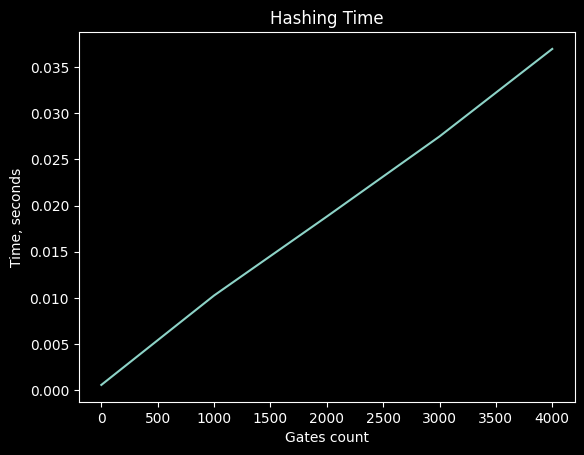

In [15]:
plt.title("Hashing Time")

plt.xlabel("Gates count")
plt.ylabel("Time, seconds")

plt.plot(gates_counts, elapsed_times);

### Benchmarking

In [16]:
# %%timeit -r 10 -n 100

# get_circuit_hash(circuit)

In [17]:
%%timeit -r 1 -n 1

get_circuit_hash(circuit_decomposed)

46 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
